In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Jan 27 18:04:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_norm_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings
hp.norm_exp = 1

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 7368
-rw-rw-r-- 1 scpark scpark   66750  1월 27 18:04 events.out.tfevents.1706346199.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 18:03 save_0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

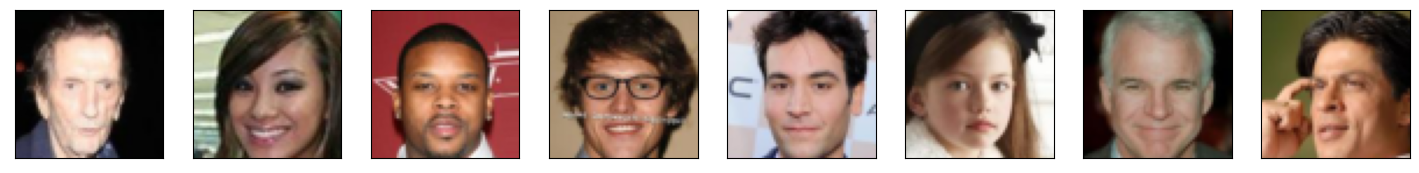

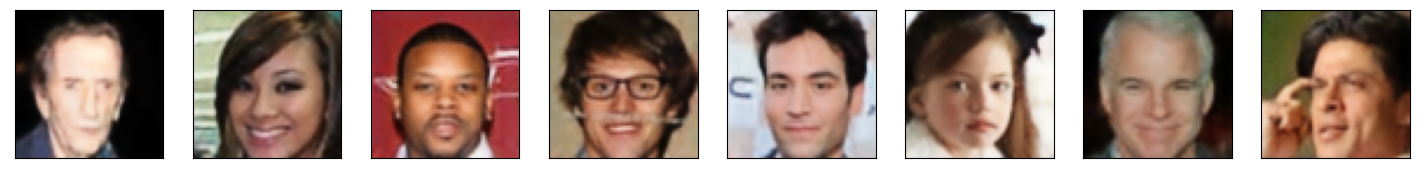

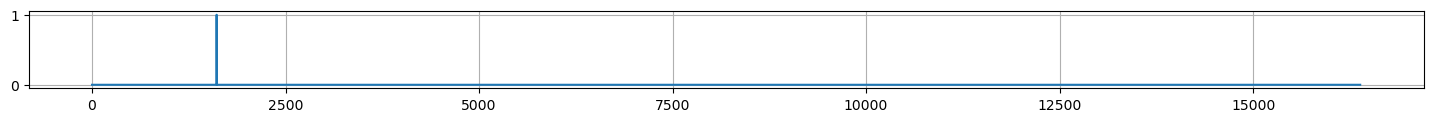

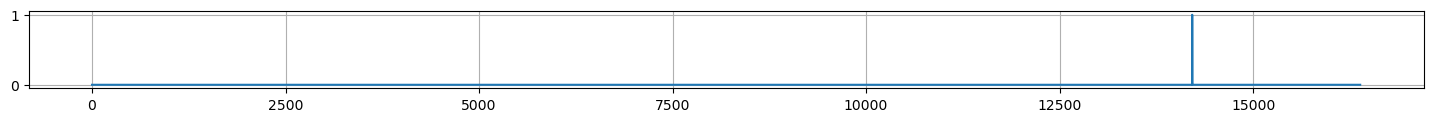

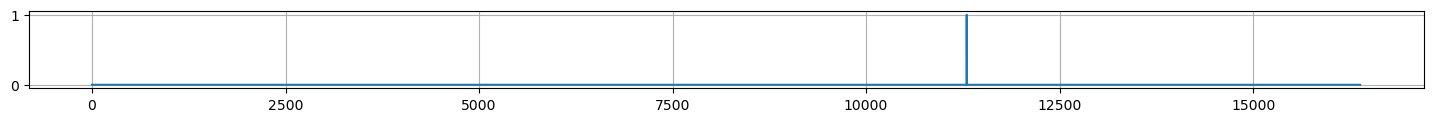

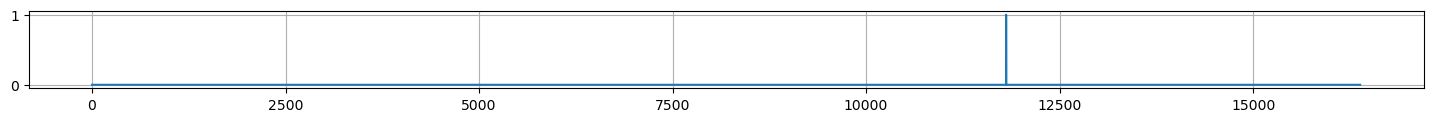

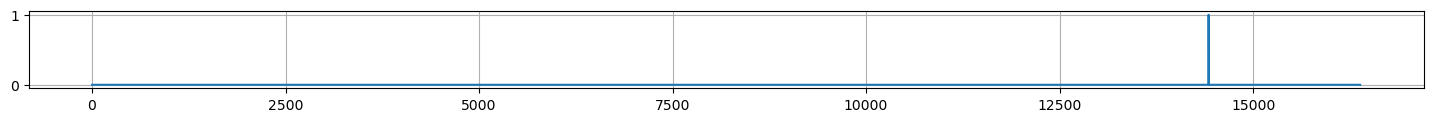

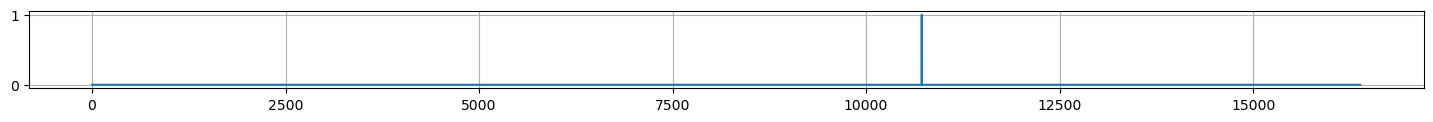

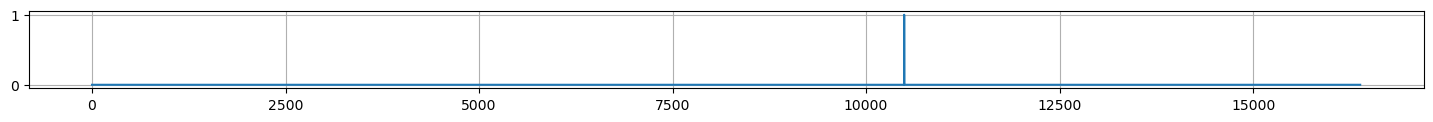

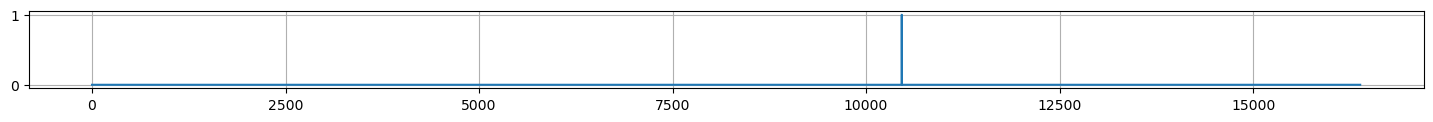

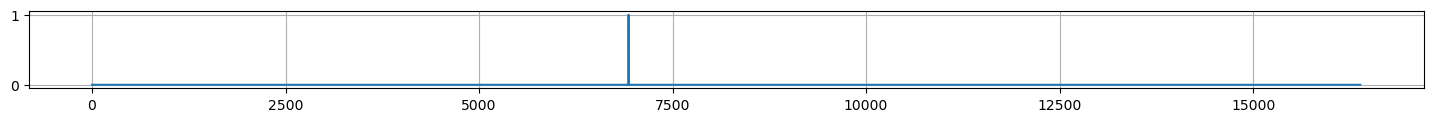

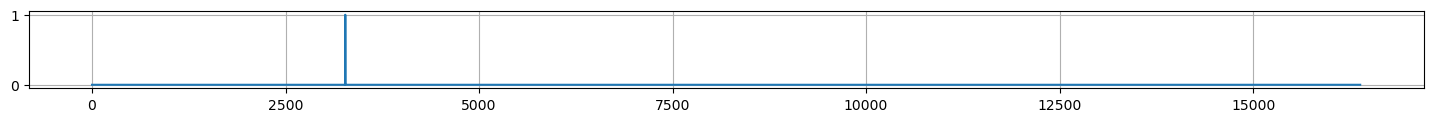

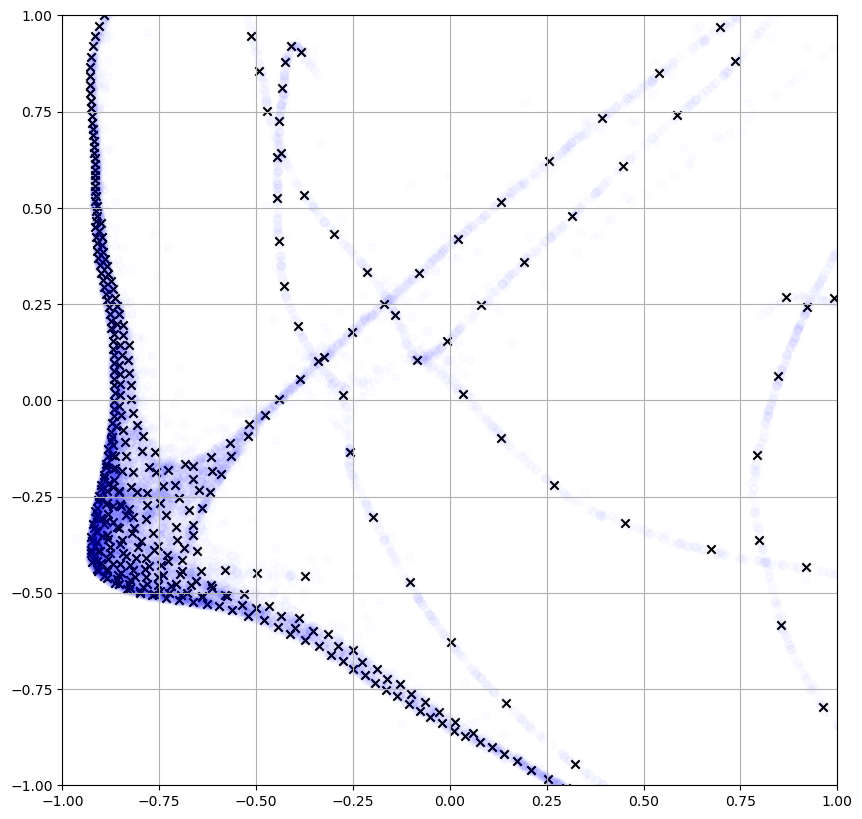

1
lse_loss 4352.7265625
commit_loss 9.179230983136222e-05
recon_loss 0.0019417591392993927
2
lse_loss 3169.62451171875
commit_loss 8.90853552846238e-05
recon_loss 0.0015310466988012195
3
lse_loss 2702.73388671875
commit_loss 9.388352918904275e-05
recon_loss 0.0012779358075931668
4
lse_loss 2768.823974609375
commit_loss 9.235634934157133e-05
recon_loss 0.0011450685560703278
5
lse_loss 2873.58984375
commit_loss 9.185131057165563e-05
recon_loss 0.0014846775447949767
6
lse_loss 2674.914306640625
commit_loss 9.11060706130229e-05
recon_loss 0.0012734851334244013
7
lse_loss 2573.740478515625
commit_loss 8.811747829895467e-05
recon_loss 0.0012174121802672744
8
lse_loss 2516.376220703125
commit_loss 9.272145689465106e-05
recon_loss 0.0013248928589746356
9
lse_loss 2455.945068359375
commit_loss 8.656916907057166e-05
recon_loss 0.0011037541553378105
10
lse_loss 2715.92333984375
commit_loss 9.105079516302794e-05
recon_loss 0.0012083275942131877
11
lse_loss 2463.36328125
commit_loss 8.5561550804413

87
lse_loss 1811.9169921875
commit_loss 8.045860886340961e-05
recon_loss 0.0009427645127288997
88
lse_loss 1889.77490234375
commit_loss 8.121154678519815e-05
recon_loss 0.0008851317688822746
89
lse_loss 2229.67236328125
commit_loss 7.86473392508924e-05
recon_loss 0.0009839646518230438
90
lse_loss 2134.319580078125
commit_loss 8.578444976592436e-05
recon_loss 0.0009877941338345408
91
lse_loss 2226.881591796875
commit_loss 8.379952487302944e-05
recon_loss 0.0009694689651951194
92
lse_loss 1984.47314453125
commit_loss 8.957051613833755e-05
recon_loss 0.0008921775734052062
93
lse_loss 1758.023193359375
commit_loss 7.835263386368752e-05
recon_loss 0.000797612767200917
94
lse_loss 1889.2579345703125
commit_loss 8.356572652701288e-05
recon_loss 0.0009350753389298916
95
lse_loss 1899.776123046875
commit_loss 7.546135748270899e-05
recon_loss 0.0011229380033910275
96
lse_loss 1928.061279296875
commit_loss 8.090712071862072e-05
recon_loss 0.0010767553467303514
97
lse_loss 1844.48681640625
commit_

lse_loss 1673.967529296875
commit_loss 7.41966359782964e-05
recon_loss 0.0008609644137322903
174
lse_loss 1835.5855712890625
commit_loss 7.322413875954226e-05
recon_loss 0.0010362241882830858
175
lse_loss 1603.4825439453125
commit_loss 7.23646953701973e-05
recon_loss 0.0009233647724613547
176
lse_loss 1751.761474609375
commit_loss 7.491411815863103e-05
recon_loss 0.0009799855761229992
177
lse_loss 1723.781005859375
commit_loss 7.40927061997354e-05
recon_loss 0.0008688351372256875
178
lse_loss 1976.083984375
commit_loss 7.404346251860261e-05
recon_loss 0.000908267917111516
179
lse_loss 1842.9200439453125
commit_loss 7.567590364487842e-05
recon_loss 0.0009717241628095508
180
lse_loss 1770.0977783203125
commit_loss 7.433403516188264e-05
recon_loss 0.0010013803839683533
181
lse_loss 2124.94921875
commit_loss 7.937605550978333e-05
recon_loss 0.0009600066114217043
182
lse_loss 1693.9052734375
commit_loss 7.851145346648991e-05
recon_loss 0.0009700185619294643
183
lse_loss 1659.913818359375
co

258
lse_loss 1592.971435546875
commit_loss 7.415374420816079e-05
recon_loss 0.0009672539308667183
259
lse_loss 1933.3543701171875
commit_loss 7.288018969120458e-05
recon_loss 0.0009228416602127254
260
lse_loss 1888.8585205078125
commit_loss 7.385755452560261e-05
recon_loss 0.0009663808159530163
261
lse_loss 1581.20068359375
commit_loss 7.332718087127432e-05
recon_loss 0.0008943124557845294
262
lse_loss 1582.89501953125
commit_loss 7.225602166727185e-05
recon_loss 0.0010154529009014368
263
lse_loss 1916.3310546875
commit_loss 7.614701462443918e-05
recon_loss 0.0011296608718112111
264
lse_loss 1740.918701171875
commit_loss 7.141234527807683e-05
recon_loss 0.0009384956210851669
265
lse_loss 2012.096435546875
commit_loss 7.306587940547615e-05
recon_loss 0.0010177965741604567
266
lse_loss 1843.21484375
commit_loss 8.25313400127925e-05
recon_loss 0.001073596766218543
267
lse_loss 1810.9498291015625
commit_loss 7.613695925101638e-05
recon_loss 0.0010307341581210494
268
lse_loss 1764.535278320

345
lse_loss 2025.3770751953125
commit_loss 7.290624489542097e-05
recon_loss 0.0009304487612098455
346
lse_loss 1791.3492431640625
commit_loss 7.294802344404161e-05
recon_loss 0.0011181328445672989
347
lse_loss 2129.03173828125
commit_loss 7.45693250792101e-05
recon_loss 0.0009480401640757918
348
lse_loss 1648.501953125
commit_loss 7.265976455528289e-05
recon_loss 0.0008467018487863243
349
lse_loss 1701.013916015625
commit_loss 7.48931197449565e-05
recon_loss 0.0010908209951594472
350
lse_loss 1570.7806396484375
commit_loss 7.116062624845654e-05
recon_loss 0.0010351387318223715
351
lse_loss 1580.0078125
commit_loss 7.528156857006252e-05
recon_loss 0.0009452674421481788
352
lse_loss 1715.4241943359375
commit_loss 7.13054760126397e-05
recon_loss 0.0011831722222268581
353
lse_loss 1551.572265625
commit_loss 7.685089076403528e-05
recon_loss 0.001184574095532298
354
lse_loss 1559.3360595703125
commit_loss 7.554388139396906e-05
recon_loss 0.001094327075406909
355
lse_loss 1536.961669921875
c

430
lse_loss 1783.7010498046875
commit_loss 7.828936213627458e-05
recon_loss 0.0012390827760100365
431
lse_loss 1750.509521484375
commit_loss 7.475196616724133e-05
recon_loss 0.0011232250835746527
432
lse_loss 1659.106689453125
commit_loss 7.764477777527645e-05
recon_loss 0.0010780614102259278
433
lse_loss 1734.8741455078125
commit_loss 8.560330024920404e-05
recon_loss 0.0011861709645017982
434
lse_loss 1628.819091796875
commit_loss 7.725296018179506e-05
recon_loss 0.0010260043200105429
435
lse_loss 1386.204345703125
commit_loss 8.205509220715612e-05
recon_loss 0.0011669204104691744
436
lse_loss 1654.0166015625
commit_loss 7.872343121562153e-05
recon_loss 0.0011067846789956093
437
lse_loss 1621.097900390625
commit_loss 7.993150211405009e-05
recon_loss 0.0010441694175824523
438
lse_loss 1526.1031494140625
commit_loss 8.250665268860757e-05
recon_loss 0.0010024870280176401
439
lse_loss 1396.65966796875
commit_loss 8.026455179788172e-05
recon_loss 0.0011180563597008586
440
lse_loss 1381.33

515
lse_loss 1862.9683837890625
commit_loss 7.432466372847557e-05
recon_loss 0.0013346439227461815
516
lse_loss 1737.0362548828125
commit_loss 7.573943003080785e-05
recon_loss 0.0013793481048196554
517
lse_loss 1935.330322265625
commit_loss 7.664754230063409e-05
recon_loss 0.0013043985236436129
518
lse_loss 1658.922607421875
commit_loss 7.520249346271157e-05
recon_loss 0.0011930358596146107
519
lse_loss 1496.6533203125
commit_loss 6.984452193137258e-05
recon_loss 0.0012937032151967287
520
lse_loss 1868.7437744140625
commit_loss 7.286084291990846e-05
recon_loss 0.0014557980466634035
521
lse_loss 1525.8719482421875
commit_loss 7.383681804640219e-05
recon_loss 0.0010576974600553513
522
lse_loss 1968.6224365234375
commit_loss 7.348270446527749e-05
recon_loss 0.0012165640946477652
523
lse_loss 1425.011962890625
commit_loss 7.443096546921879e-05
recon_loss 0.0012224647216498852
524
lse_loss 1577.56396484375
commit_loss 7.11374741513282e-05
recon_loss 0.001173224882222712
525
lse_loss 1526.19

600
lse_loss 1481.1846923828125
commit_loss 8.0752550275065e-05
recon_loss 0.0011456835782155395
601
lse_loss 1418.0582275390625
commit_loss 8.193925168598071e-05
recon_loss 0.0012101948959752917
602
lse_loss 1507.6656494140625
commit_loss 8.486660954076797e-05
recon_loss 0.001177578466013074
603
lse_loss 1468.7486572265625
commit_loss 7.866803207434714e-05
recon_loss 0.001076650689356029
604
lse_loss 1745.4591064453125
commit_loss 7.977869972819462e-05
recon_loss 0.001184647437185049
605
lse_loss 1315.3453369140625
commit_loss 7.541995728388429e-05
recon_loss 0.0011243599001318216
606
lse_loss 1461.02490234375
commit_loss 7.450693374266848e-05
recon_loss 0.0012097577564418316
607
lse_loss 1633.56982421875
commit_loss 7.791039388393983e-05
recon_loss 0.0012938568834215403
608
lse_loss 1737.0057373046875
commit_loss 8.698616875335574e-05
recon_loss 0.0013466080417856574
609
lse_loss 1701.166015625
commit_loss 7.751873636152595e-05
recon_loss 0.0012067810166627169
610
lse_loss 1569.36877

685
lse_loss 1401.21630859375
commit_loss 7.670942432014272e-05
recon_loss 0.0011937303934246302
686
lse_loss 1388.816162109375
commit_loss 7.747625932097435e-05
recon_loss 0.0014238510048016906
687
lse_loss 1655.8314208984375
commit_loss 7.902896322775632e-05
recon_loss 0.0012339308159425855
688
lse_loss 1520.89892578125
commit_loss 7.63140560593456e-05
recon_loss 0.001216441160067916
689
lse_loss 1516.72509765625
commit_loss 7.644927245564759e-05
recon_loss 0.0012339649256318808
690
lse_loss 1428.5120849609375
commit_loss 7.847089727874845e-05
recon_loss 0.001084543066099286
691
lse_loss 1560.4471435546875
commit_loss 7.75057851569727e-05
recon_loss 0.0012145075015723705
692
lse_loss 1634.7320556640625
commit_loss 7.800391176715493e-05
recon_loss 0.0012179818004369736
693
lse_loss 1474.774658203125
commit_loss 8.486343722324818e-05
recon_loss 0.0012097303988412023
694
lse_loss 1659.18017578125
commit_loss 8.739595068618655e-05
recon_loss 0.0011786222457885742
695
lse_loss 1653.347290

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')